In [33]:
from scipy.special import sph_harm as sph
import astropy.io.fits as pf
from math import sqrt, pi
import healpy as hp
import numpy as np
import time
NSIDE = 1024#2048
%matplotlib notebook

In [2]:
def make_map(theta, phi, data, NSIDE):
    assert len(theta) == len(phi) == len(data)
    numPix = hp.nside2npix(NSIDE)
    e1map = np.full(numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(numPix, False, dtype=np.bool)
    counts = np.ones(numPix, dtype=np.int)
    for i,k in enumerate(data):
        index = hp.ang2pix(NSIDE, theta[i], phi[i])
        if not existance[index]:
            e1map[index] = 0
            counts[index] = 0
            existance[index] = True
        e1map[index] += k
        counts[index] += 1
    return e1map/counts, existance

In [3]:
def restructure(ellArr, emmArr, lmax, coefs):
    count = 0
    newCoefs = np.zeros(coefs.shape[0], dtype=complex)
    for ell in range(lmax):
        for emm in range(ell+1): 
            index = np.where( (ellArr==ell) * (emmArr==emm) )[0][0]
            newCoefs[count] = coefs[index]
            count += 1
    return newCoefs
 

### Creating a synthetic map
We first create a synthetic map where $f(\theta, \phi) = \sum_{l=0}^{lmax} \sum_{m=-l}^l r_{lm} Y_{lm}(\theta, \phi)$, where $r_{lm}$ is a random coefficient. Two such maps are created. One with half disk and one with full disk data. These synthetic maps are band limited, by design. Synthetic maps have only $m \ge 0$ features.

In [24]:
# parameters for the synthetic map
lmaxSynth = 8
maxNum = int((lmaxSynth+1)*(lmaxSynth+2)/2)
almSynth = np.zeros(maxNum)
ellSynth = np.zeros(maxNum)

theta = np.linspace(0, pi, 400).reshape(400, 1)
phi = np.linspace(-pi/2, pi/2, 400).reshape(1, 400)
PHI, THETA = np.meshgrid(phi, theta)

count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        if ell==0 and emm==0:
            almSynth[count] = (np.random.rand() - 0.5)*ell
            ellSynth[count] = ell
            dataHalf = almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
        else:
            almSynth[count] = (np.random.rand() - 0.5)*ell
            ellSynth[count] = ell
            dataHalf += almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
# giving the synthetic maps some rotation+MC features
dataHalf += 2000*sph(0, 1, phi, theta) + 200*sph(0, 3, phi, theta) + 20*sph(0, 5, phi, theta) +  150*sph(0, 2, phi, theta) + 15*sph(0, 60, phi, theta)
print("Half disk synth -- complete")

phi = np.linspace(-pi, pi, 400).reshape(1, 400)
PHIFULL, THETA = np.meshgrid(phi, theta)
count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        if ell==0 and emm==0:
            dataFull = almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
        else:
            dataFull += almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
# giving the synthetic maps some rotation+MC features
dataFull += 2000*sph(0, 1, phi, theta) + 200*sph(0, 3, phi, theta) + 20*sph(0, 5, phi, theta) +  150*sph(0, 2, phi, theta) + 15*sph(0, 60, phi, theta)
print("Full disk synth -- complete")

psSynth = np.zeros(lmaxSynth)
for ell in range(lmaxSynth):
    maskEll = ellSynth==ell
    psSynth[ell] = (abs(almSynth[maskEll])**2).sum()*2/(2*ell+1)
ellSynthArr = np.arange(lmaxSynth)

Half disk synth -- complete
Full disk synth -- complete


/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


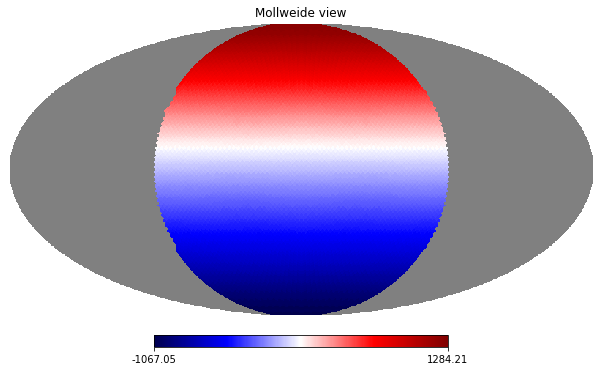

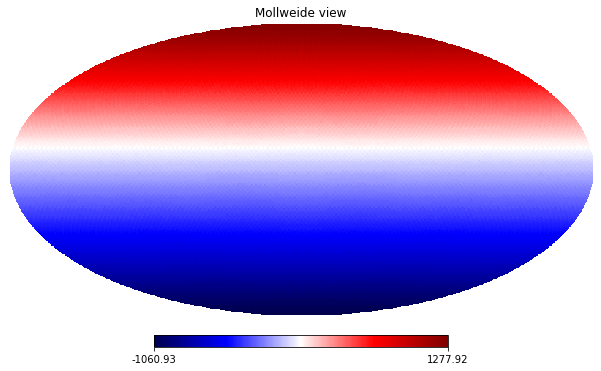

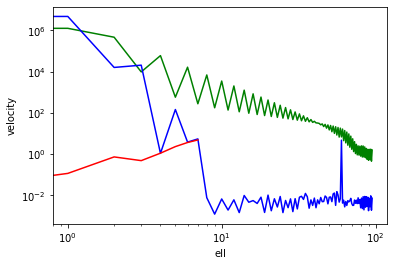

/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


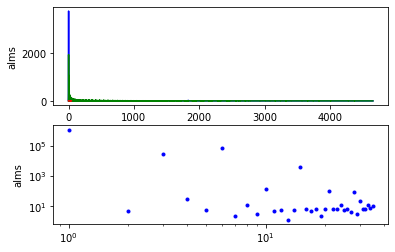

In [27]:
# Making the healPy maps
mapHalf, maskHalf= make_map(THETA.flatten(), PHI.flatten(), dataHalf.flatten(), 32)
mapFull, maskFull = make_map(THETA.flatten(), PHIFULL.flatten(), dataFull.flatten(), 32)

hp.mollview(mapHalf, cmap='seismic')
hp.mollview(mapFull, cmap='seismic')

# Computing the alms using healPy functions
powerHalf = hp.sphtfunc.anafast(mapHalf)
powerFull = hp.sphtfunc.anafast(mapFull)
almHalf = hp.sphtfunc.map2alm(mapHalf)
almFull = hp.sphtfunc.map2alm(mapFull)

mapTempFull = hp.sphtfunc.alm2map(almFull, 32)
mapTempHalf = hp.sphtfunc.alm2map(almHalf, 32)

ell = np.arange(len(powerHalf))

ellmax = hp.sphtfunc.Alm.getlmax(len(almHalf))
ellArr, emmArr = hp.sphtfunc.Alm.getlm(hp.sphtfunc.Alm.getlmax(len(almHalf)))
ellArrSynth, emmArrSynth = hp.sphtfunc.Alm.getlm(hp.sphtfunc.Alm.getlmax(len(almSynth)))


almHalfRes = restructure(ellArr, emmArr, ellmax, almHalf)
almFullRes = restructure(ellArr, emmArr, ellmax, almFull)

plt.figure()
#plt.subplot(211)
plt.loglog(ell, np.sqrt(4*pi)*powerHalf, 'g')
plt.loglog(ell, np.sqrt(4*pi)*powerFull, 'b')
plt.loglog(ellSynthArr, psSynth, 'r')
plt.xlabel("ell")
plt.ylabel("velocity")

#plt.subplot(212)
#plt.plot(ell, powerHalf, 'g')
#plt.plot(ell, powerFull, 'b')
#plt.plot(ellSynthArr, psSynth, 'r')
#plt.xlabel("ell")
#plt.ylabel("velocity")
plt.show()

plt.figure()
plt.subplot(211)
plt.plot(np.sqrt(np.sqrt(4*pi))*abs(almFullRes), 'b')
plt.plot(np.sqrt(np.sqrt(4*pi))*abs(almHalfRes), 'g')
plt.plot(abs(almSynth), 'r')
plt.ylabel('alms')

plt.subplot(212)
plt.loglog( abs(np.sqrt(np.sqrt(4*pi))*abs(almFullRes)[:len(almSynth)] - abs(almSynth))/abs(almSynth)*100, '.b')
#plt.loglog( abs(np.sqrt(4*pi)*abs(almHalfRes)[:len(almSynth)] - abs(almSynth))/abs(almSynth)*100, '.g')
#plt.loglog(abs(almSynth), 'r')
plt.ylabel('alms')

plt.show()

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


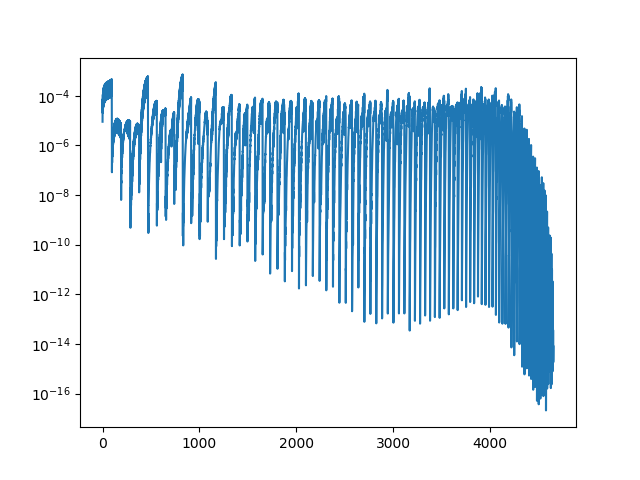

<IPython.core.display.Javascript object>


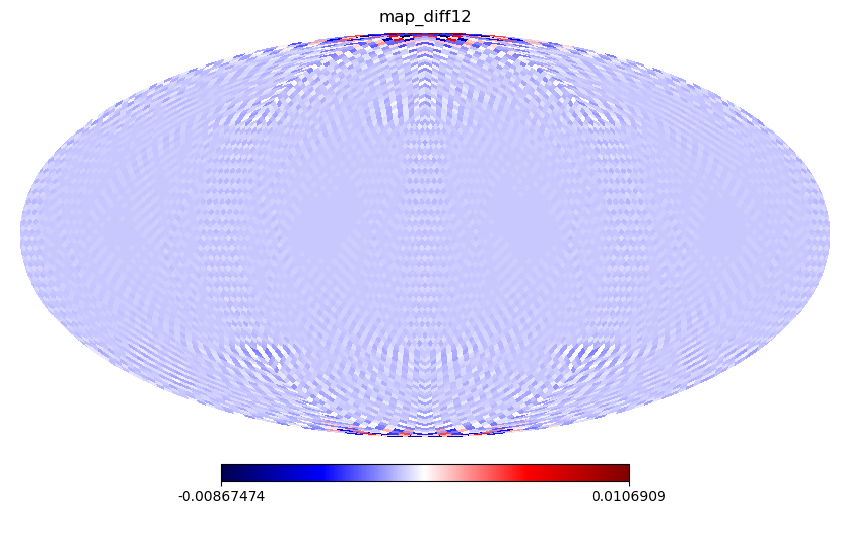

<IPython.core.display.Javascript object>


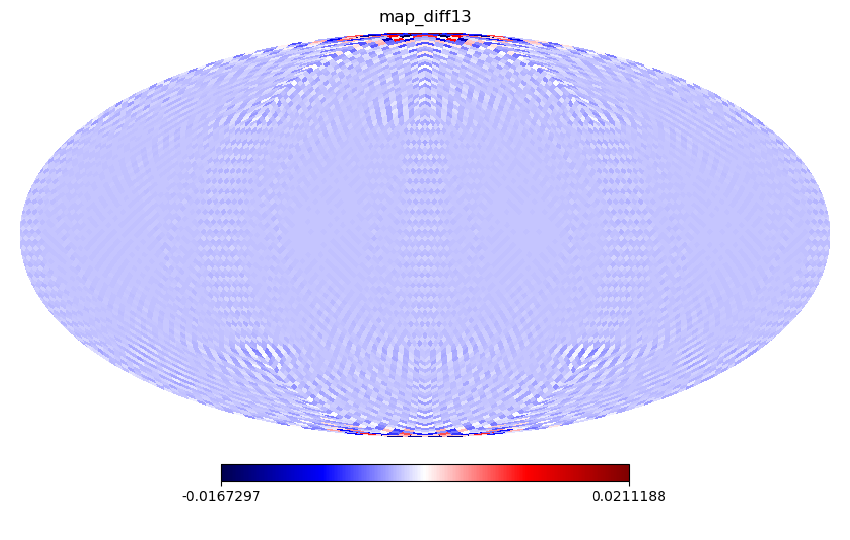

<IPython.core.display.Javascript object>


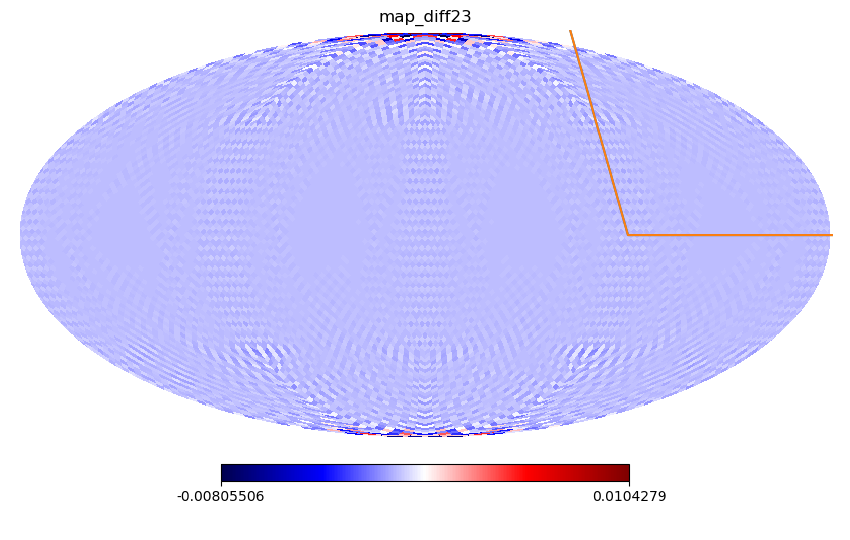

"\nmaskPerc = abs(mapPerc1)<5.00\nmapPerc1[maskPerc] = 10000.0\nmaskPerc = abs(mapPerc2)<5\nmapPerc2[maskPerc] = 10000.0\n\nhp.mollview(mapPerc1, cmap='seismic')\nplt.title('map_full')\nplt.show()\n\nhp.mollview(mapPerc2, cmap='seismic')\nplt.title('map_full')\nplt.show()\n\n"

In [58]:
mapPerc1 = (mapFull - mapTempFull)/mapFull*100
mapPerc2 = (mapHalf - mapTempHalf)/mapHalf*100

alm1 = hp.sphtfunc.map2alm(mapTempFull)
map1 = hp.sphtfunc.alm2map(alm1, 32)
alm2 = hp.sphtfunc.map2alm(map1)
map2 = hp.sphtfunc.alm2map(alm2, 32)
alm3 = hp.sphtfunc.map2alm(map2)
map3 = hp.sphtfunc.alm2map(alm3, 32)
mapDiff12 = map1 - map2
mapDiff13 = map1 - map3
mapDiff23 = map2 - map3

plt.figure()
plt.semilogy( abs( almFull - almTempFull ) )
plt.show()

# masking
"""
maskPerc = abs(mapPerc1)<5.00
mapPerc1[maskPerc] = 10000.0
maskPerc = abs(mapPerc2)<5
mapPerc2[maskPerc] = 10000.0

hp.mollview(mapPerc1, cmap='seismic')
plt.title('map_full')
plt.show()

hp.mollview(mapPerc2, cmap='seismic')
plt.title('map_full')
plt.show()

"""

<IPython.core.display.Javascript object>


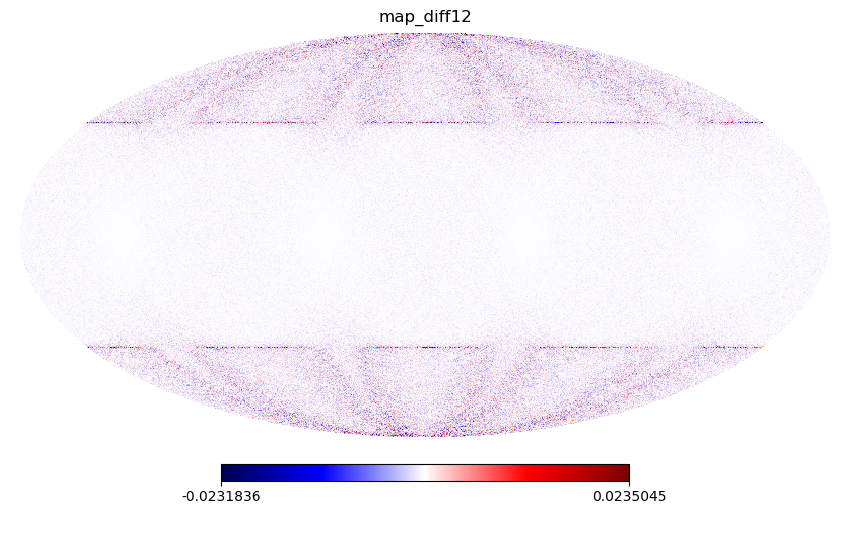

<IPython.core.display.Javascript object>


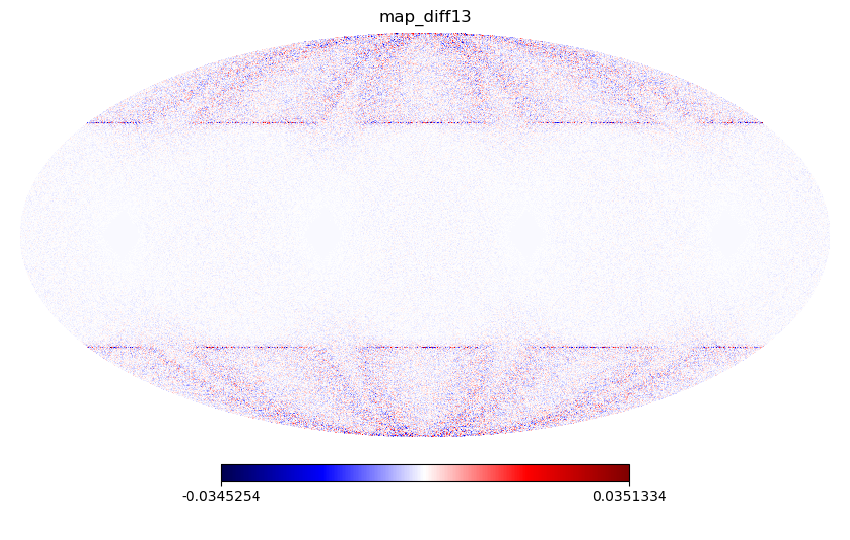

<IPython.core.display.Javascript object>


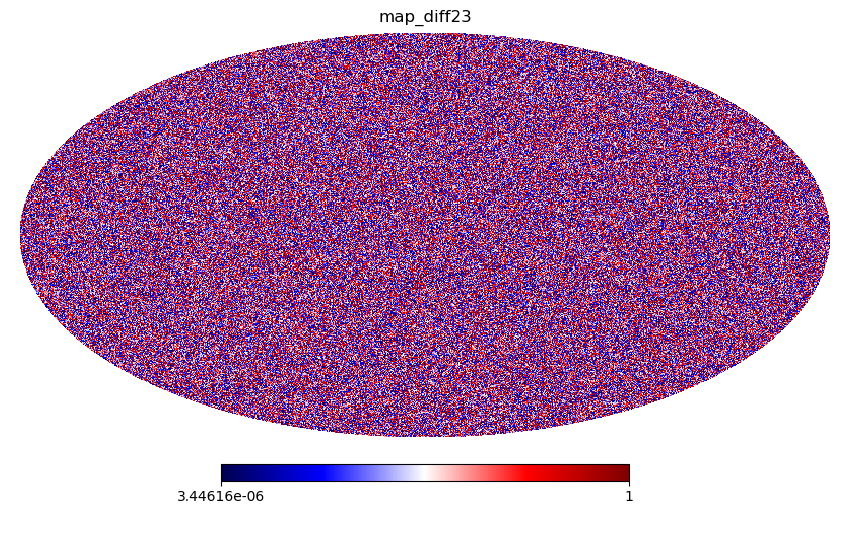

In [61]:
hp.mollview(mapDiff12, cmap='seismic')
plt.title('map_diff12')
plt.show()

hp.mollview(mapDiff13, cmap='seismic')
plt.title('map_diff13')
plt.show()

hp.mollview(mapTempFull, cmap='seismic')
plt.title('map_diff23')
plt.show()


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


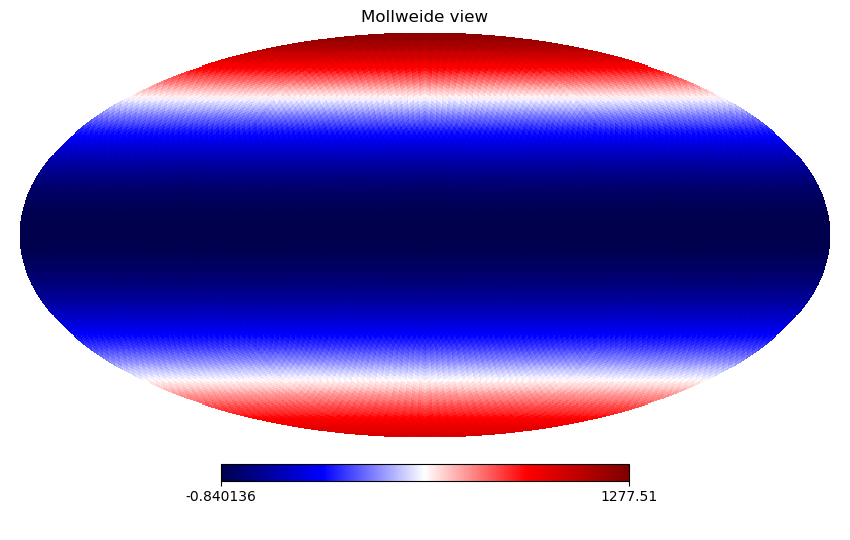

<IPython.core.display.Javascript object>


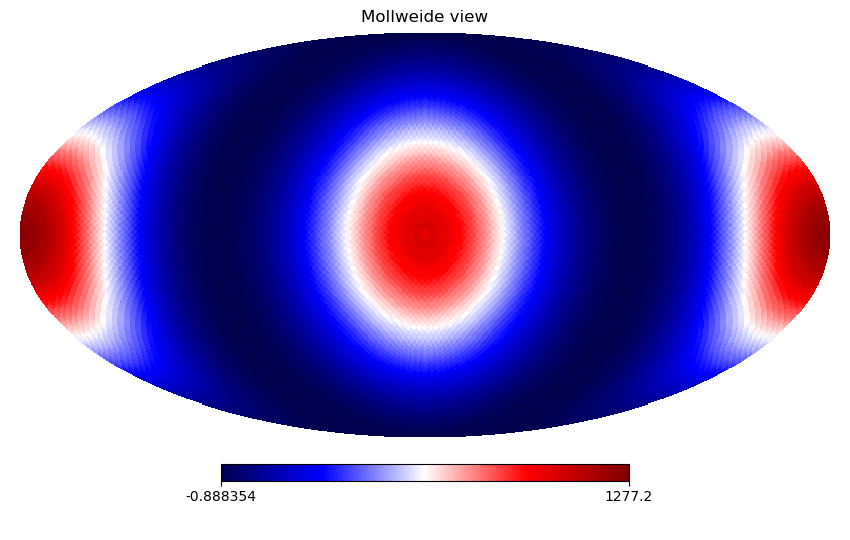

In [34]:
nside = 32
npix = hp.nside2npix(nside)
ipix = np.arange(npix)
theta, phi = hp.pix2ang(nside, ipix)

lr = np.cos(theta)
lt = -np.sin(theta)

apod = 1.0#/(1 + np.exp(35*(thetaMapRot - np.pi/2.3)))
map_0 = mapFull * lr * apod
map_p1 = - mapFull * lt / sqrt(2) * apod
map_m1 = - mapFull * lt / sqrt(2) * apod
#map_trans = [(map_p1 + map_m1)/2, -1j*(map_p1 - map_m1)/2]
map_trans = [map_p1, 0.0*map_p1]
map_0[~maskFull] = hp.UNSEEN
map_trans[0][~maskFull] = 0.0#hp.UNSEEN
map_trans[1][~maskFull] = 0.0#hp.UNSEEN
alm_r = hp.map2alm(map_0)
alm_pm = hp.map2alm_spin(map_trans, 1)
alm_v, alm_w = alm_pm[0], alm_pm[1]
alm_p = alm_pm[0]
alm_m = alm_pm[1]
alm_vRot = -alm_p
alm_wRot = -1j*alm_m


alm2r = alm_r.copy()
alm2p = alm_p.copy()
alm2m = alm_m.copy()
hp.rotate_alm(alm2r, psi=0.0, theta=-pi/2, phi=0.0)
#hp.rotate_alm(alm2r, psi=0.0, theta=pi/2, phi=0.0)
hp.rotate_alm(alm2p, psi=0.0, theta=pi/2, phi=0.0)
hp.rotate_alm(alm2m, psi=0.0, theta=pi/2, phi=0.0)
map2 = hp.alm2map(alm2r, 32)
hp.mollview(map_0, cmap='seismic')
hp.mollview(map2, cmap='seismic')

2.2079433491787784e-09

In [79]:
mapp1 = hp.read_map("./COM_CMB_IQU-nilc-field-Int_2048_R2.01_full.fits")
diff = mapp1 - hp.alm2map(hp.map2alm(mapp1), 2048)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


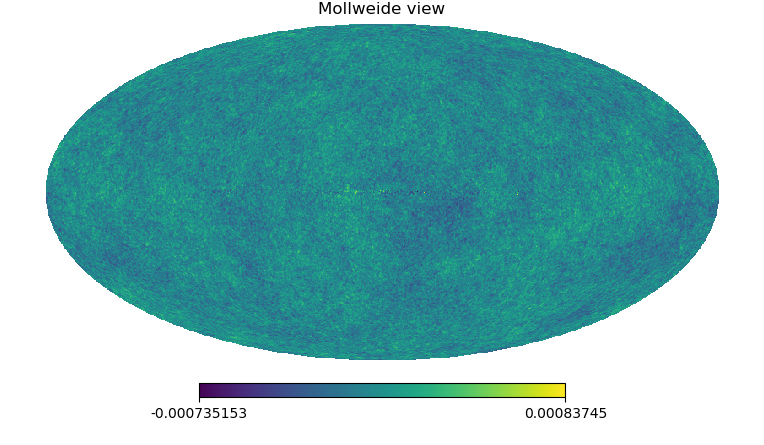

In [81]:
hp.mollview(mapp1)

<IPython.core.display.Javascript object>


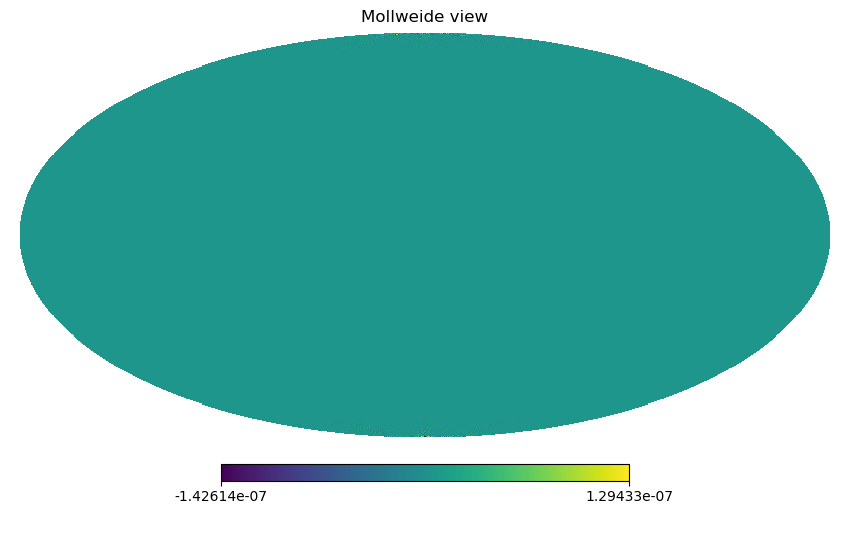

In [80]:
hp.mollview(diff)

<IPython.core.display.Javascript object>


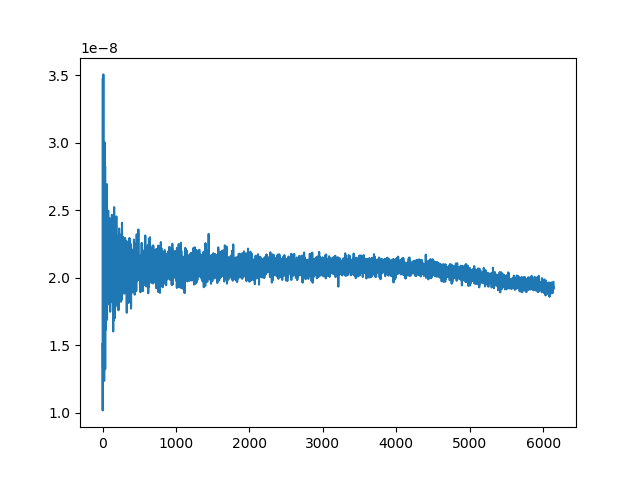

In [75]:
plt.figure()
plt.plot(hp.anafast(map1)[2:])
plt.show()

<IPython.core.display.Javascript object>


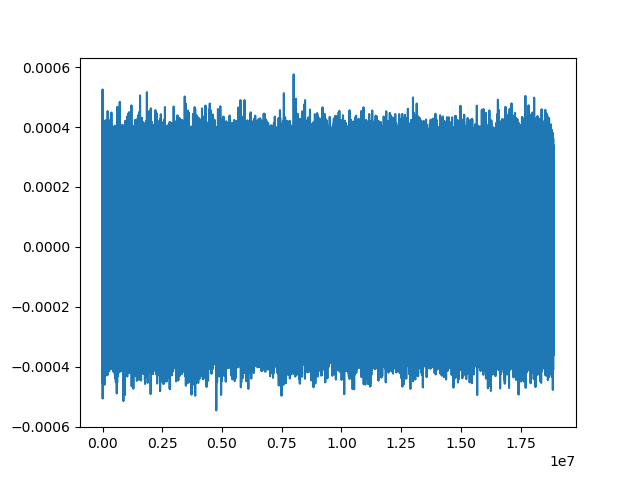

In [72]:
plt.figure()
plt.plot(alm1[2:])
plt.show()

### Spherical Harmonic transform -- Explicit computation

In [21]:
from scipy.integrate import simps
phiHalf = np.linspace(-pi/2, pi/2, 400).reshape(1, 400)
comps = np.zeros(20)
ellrange = np.zeros(20)
for i in range(50, 70):
    comps[int(i-50)] = simps( simps(dataHalf*np.sin(theta)*sph(0, i, phi, theta).conjugate(), x=theta.flatten(), axis=0), x=phi.flatten(), axis=0)
    ellrange[int(i-50)] = i
    print(f"comp{i}: value = {comps[int(i-50)]}")
#   
compsHalf = np.zeros(maxNum, dtype=complex)
compsFull = np.zeros(maxNum, dtype=complex)
count = 0
for ell in range(lmaxSynth):
    print(f"ell = {ell}")
    for emm in range(ell+1):
        compsHalf[count] = simps( simps(dataHalf*np.sin(theta)*sph(emm, ell, phiHalf, theta).conjugate(), x=theta.flatten(), axis=0), x=phiHalf.flatten(), axis=0)
        compsFull[count] = simps( simps(dataFull*np.sin(theta)*sph(emm, ell, phi, theta).conjugate(), x=theta.flatten(), axis=0), x=phi.flatten(), axis=0)
        count += 1

/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


comp50: value = 0.000855466658731859
comp51: value = 0.002186114850861078
comp52: value = 0.000770617686145362
comp53: value = 0.0019909475253439795
comp54: value = 0.0006964011415523645
comp55: value = 0.0018206675136699974
comp56: value = 0.0006310922896099568
comp57: value = 0.001671457952830576
comp58: value = 0.000573294916078292
comp59: value = 0.0015402018759454144
comp60: value = 0.0005218694961321061
comp61: value = 0.0014243352001614977
comp62: value = 0.0004758789664804572
comp63: value = 0.0013217342910592314
comp64: value = 0.000434547350057949
comp65: value = 0.0012306291516075527
comp66: value = 0.00039722787544305957
comp67: value = 0.0011495358016076701
comp68: value = 0.000363378187247184
comp69: value = 0.0010772031700493573
ell = 0
ell = 1
ell = 2
ell = 3
ell = 4
ell = 5
ell = 6
ell = 7


<IPython.core.display.Javascript object>


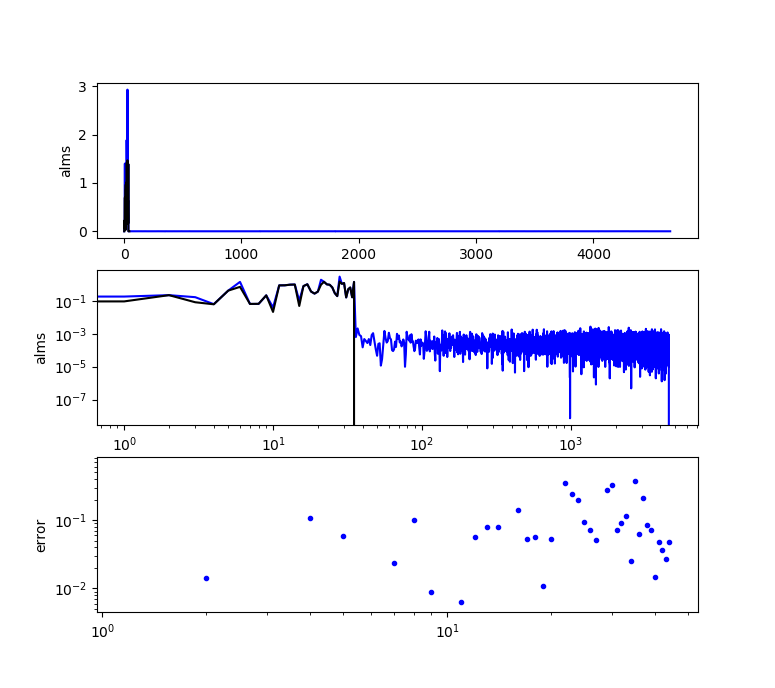

In [27]:
plt.figure()
plt.subplot(311)
plt.plot(abs(almFullRes), 'b')
plt.plot(abs(compsFull)/2, 'black')
plt.ylabel('alms')

plt.subplot(312)
plt.loglog(abs(almFullRes), 'b')
plt.loglog(abs(compsFull)/2, 'black')
plt.ylabel('alms')

plt.subplot(313)
plt.loglog(abs( abs(almFullRes)[:45] - abs(compsFull)/2 )*100, '.b')
plt.ylabel('error')

plt.show()

In [64]:
thetaMap = fits.open("theta.fits")[0].data
phiMap = fits.open("phi.fits")[0].data

In [67]:
def avgDer(x):
    maskNaN = ~np.isnan(x)
    d1 = x[1:, :] - x[:-1, :]
    d2 = x[:, 1:] - x[:, :-1]
    dAvg = np.zeros(x.shape)
    dAvg[1:, 1:] = (d1[:, 1:] + d1[:, :-1] + d2[1:, :] + d2[:-1, :])/4.
    return dAvg

<IPython.core.display.Javascript object>


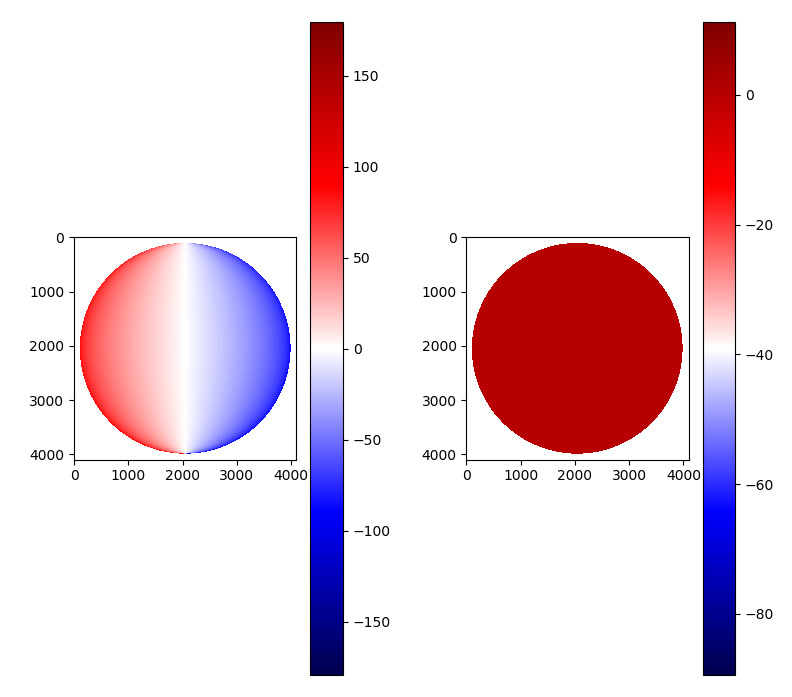

In [81]:
d_theta = avgDer(thetaMap)
d_phi = avgDer(phiMap)

dA = np.sin(theta) * d_theta * d_phi

maskNaN = ~np.isnan(dA)

vmax = dA[maskNaN].max()
vmin = dA[maskNaN].min()

plt.figure()

plt.subplot(121)
im = plt.imshow(phiMap, cmap='seismic')
plt.colorbar(im)

plt.subplot(122)
im = plt.imshow(dA, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar(im)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


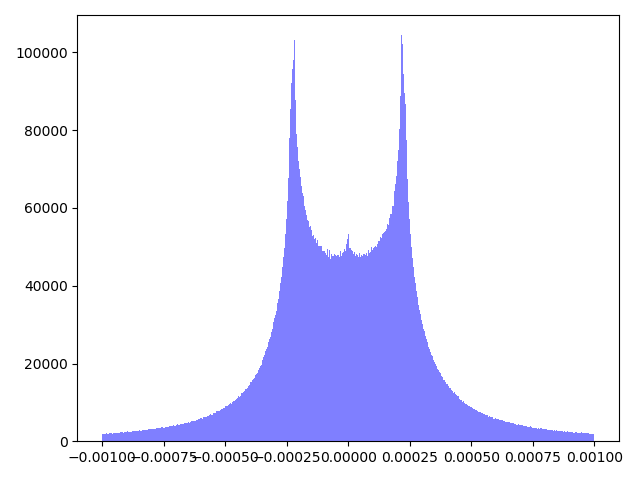

In [97]:
mask2 = abs(dA[maskNaN])<1e-3
num_bins = 500
plt.figure()
n, bins, patches = plt.hist(dA[maskNaN].flatten()[mask2], num_bins, facecolor='blue', alpha=0.5)
plt.tight_layout()
plt.show()

-7.988397535794805e-06